In [1]:
from matplotlib import pyplot as plt
import torch
from torch.nn import functional as F
from scipy.interpolate import griddata

In [2]:
import os
os.chdir('/home/ron/Documents/DenseSeg')
print(os.getcwd())
from dataset.jsrt_dataset import JSRTDataset, TRAINING_SHAPES

# Real data
anatomy = 'left_lung'
anatomy_idx = JSRTDataset.get_anatomical_structure_index()[anatomy]
shapes = (TRAINING_SHAPES[:, anatomy_idx[0]:anatomy_idx[1]] + 1) / 2 * 256

idx = 0
atlas = shapes.mean(0)
sample = shapes[idx]
del shapes

/home/ron/Documents/DenseSeg


In [3]:
# atlas = torch.tensor([[102.0609, 177.6891],
#         [100.3509, 167.2350],
#         [ 99.8928, 156.7809],
#         [101.3616, 146.3269],
#         [104.3809, 135.8744],
#         [108.5797, 125.4719],
#         [115.2310, 120.4498],
#         [122.2730, 117.6683],
#         [129.4587, 116.2368],
#         [136.6444, 115.6241],
#         [143.8301, 115.6138],
#         [151.0018, 116.4096],
#         [158.1219, 118.3938],
#         [168.0190, 130.0435],
#         [177.6917, 141.9828],
#         [185.9219, 154.3102],
#         [191.0260, 166.8396],
#         [191.5315, 178.9557],
#         [187.4750, 189.7094],
#         [177.1373, 193.7379],
#         [166.4234, 194.9875],
#         [155.6438, 195.0586],
#         [144.8578, 194.2820],
#         [134.0719, 192.5055],
#         [123.2859, 189.5535],
#         [112.5938, 184.9000]])
# 
# sample = torch.tensor([[114.7500, 181.7500],
#         [109.7500, 170.0000],
#         [106.7500, 158.2500],
#         [107.7500, 146.5000],
#         [111.2500, 134.7500],
#         [116.7500, 123.0000],
#         [122.8215, 117.1785],
#         [128.8927, 112.7500],
#         [134.9642, 110.0358],
#         [141.0358, 107.7500],
#         [147.1073, 106.0000],
#         [153.1785, 105.0000],
#         [159.2500, 104.5000],
#         [171.3750, 119.1250],
#         [182.0000, 133.7500],
#         [192.6250, 148.3750],
#         [198.2500, 163.0000],
#         [196.6250, 177.6250],
#         [185.0000, 189.7500],
#         [176.2188, 192.0000],
#         [167.4375, 192.0000],
#         [158.6562, 191.7500],
#         [149.8750, 191.5000],
#         [141.0938, 190.5000],
#         [132.3125, 189.0625],
#         [123.5312, 186.0000]])

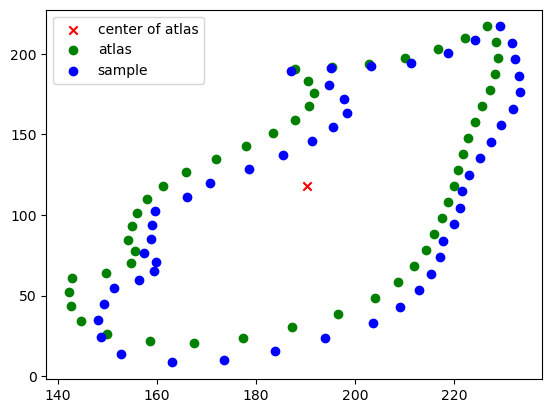

In [4]:
plt.scatter(atlas.mean(0)[0], atlas.mean(0)[1], c='r', marker='x', label='center of atlas')
plt.scatter(atlas[:, 0], atlas[:, 1], c='g', label='atlas')
plt.scatter(sample[:, 0], sample[:, 1], c='b', label='sample')
plt.legend()

In [5]:
# bounding box
bb_min = torch.min(atlas, dim=0).values
bb_max = torch.max(atlas, dim=0).values
range_atlas = bb_max - bb_min
range_atlas_int = range_atlas.floor().int()

In [6]:
pts = atlas.clone()
center_of_mass = pts.mean(0, keepdim=True)
pts_centered = pts - center_of_mass
l1 = pts_centered.abs().max(-1, keepdim=True).values
#values = (pts_centered / l1).t()

O = round(range_atlas.max().item() / 2)
offset = torch.linspace(1/O, 1, O)
pts = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) + center_of_mass.unsqueeze(0)
pts = pts.view(-1, 2)
values = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) / l1.unsqueeze(0)
values = values.view(-1, 2)

# for i in range(1, 20):
#     pts = torch.cat([pts, pts_centered * i/20+center_of_mass], dim=0)
#     values = torch.cat([values, (pts_centered * i/20/l1).t()], dim=1)

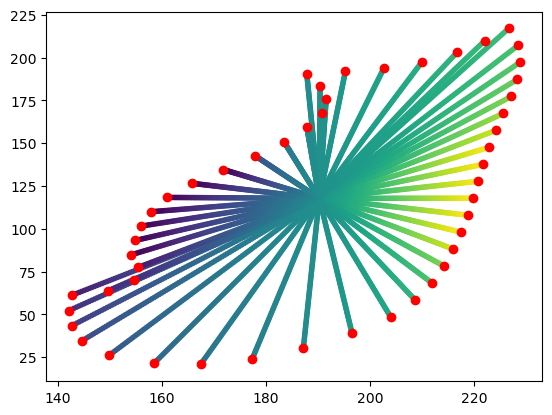

In [7]:
plt.scatter(pts[:, 0], pts[:, 1], c=values[:, 0], marker='.')
plt.scatter(atlas[:, 0], atlas[:, 1], c='r')

In [8]:
dist = torch.cdist(pts, atlas)
atlas_pts_value_idx = torch.argmin(dist, dim=0)
atlas_pts_values = pts_centered / l1
torch.eq(atlas_pts_values, values[atlas_pts_value_idx]).all()

tensor(True)

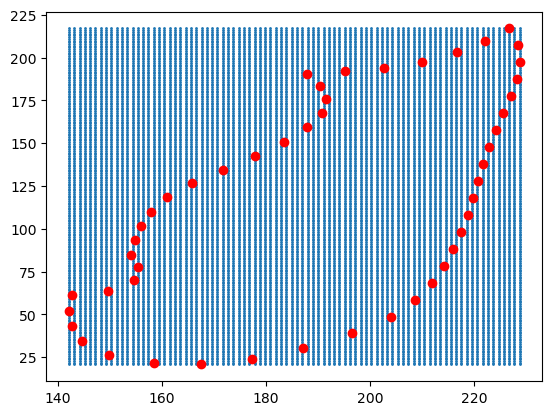

In [9]:
# create grid for bounding box keeping the same amount of "pixel" as in the image
grid = torch.meshgrid(torch.linspace(bb_min[0], bb_max[0], range_atlas_int[0]), torch.linspace(bb_min[1], bb_max[1], range_atlas_int[1]), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

plt.scatter(grid[:, 0], grid[:, 1], s=1)
plt.scatter(atlas[:, 0], atlas[:, 1], c='r')

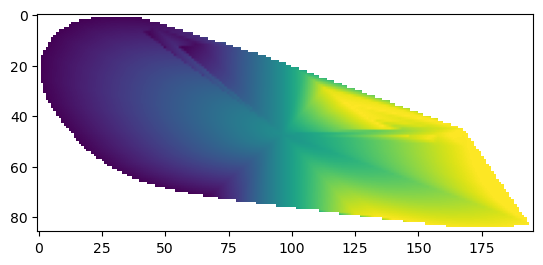

In [10]:
uv = griddata(pts, values, grid, method='linear', rescale=True)
uv = torch.from_numpy(uv)
uv = uv.reshape(range_atlas_int[0], range_atlas_int[1], 2).permute(2, 0, 1)

plt.imshow(uv[1])

In [11]:
import cv2
import numpy as np

def flow2img(flow, BGR=True):
	x, y = flow[0, 0,:,:], flow[0, 1, :, :]
	hsv = np.zeros((flow.shape[2], flow.shape[3], 3), dtype = np.uint8)
	ma, an = cv2.cartToPolar(x, y, angleInDegrees=True)
	hsv[..., 0] = (an / 2).astype(np.uint8)
	hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)
	hsv[..., 2] = 255
	img = []
	if BGR:
		img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
		return img
	else:
		img[0] = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)
		img[1] = cv2.cvtColor(y, cv2.COLOR_HSV2RGB)
		return img

/tmp/ipykernel_47394/1197566685.py:8: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = (an / 2).astype(np.uint8)
/tmp/ipykernel_47394/1197566685.py:9: RuntimeWarning: invalid value encountered in cast
  hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)


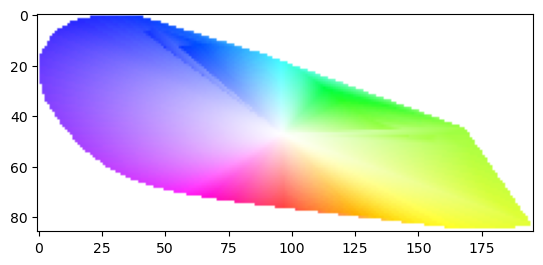

In [12]:
uv_plotting = flow2img(uv.unsqueeze(0).numpy())
plt.imshow(uv_plotting)

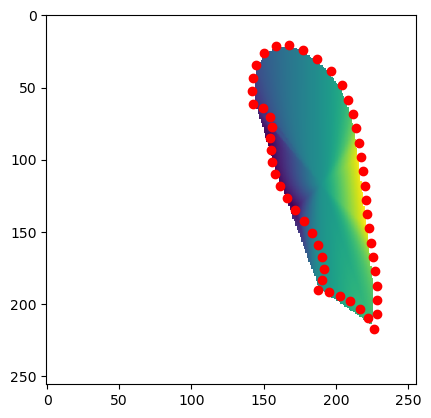

In [13]:
img_size = [256, 256]
bb_max_int = bb_max.round().int()
bb_min_int = bb_min.round().int()
target_uv_img_shape = (bb_max_int - bb_min_int).tolist()
resized_uv_img = F.interpolate(uv.unsqueeze(0), target_uv_img_shape, mode='bilinear', align_corners=True).squeeze(0)

uv_img_space = torch.full((2, img_size[0], img_size[1]), torch.nan)
uv_img_space[:, bb_min_int[0]:bb_max_int[0], bb_min_int[1]:bb_max_int[1]] = resized_uv_img
uv_img_space = uv_img_space.transpose(1, 2)
# uv_img_space_masked[:, seg_mask.logical_not()] = torch.nan

plt.imshow(uv_img_space[0])
plt.scatter(atlas[:, 0], atlas[:, 1], c='r')

In [14]:
# bounding box
bb_min = torch.min(sample, dim=0).values
bb_max = torch.max(sample, dim=0).values
range_sample = bb_max - bb_min
range_sample_int = range_sample.round().int()

In [15]:
pts = sample.clone()
center_of_mass = pts.mean(0, keepdim=True)
pts_centered = pts - center_of_mass
l1 = pts_centered.abs().max(-1, keepdim=True).values
#values = (pts_centered / l1).t()

O = round(range_sample_int.max().item() / 2)
offset = torch.linspace(1/O, 1, O)
pts = pts_centered.unsqueeze(0) * offset.view(O, 1, 1) + center_of_mass.unsqueeze(0)
pts = pts.view(-1, 2)
values = atlas_pts_values.unsqueeze(0) * offset.view(O, 1, 1)
values = values.view(-1, 2)

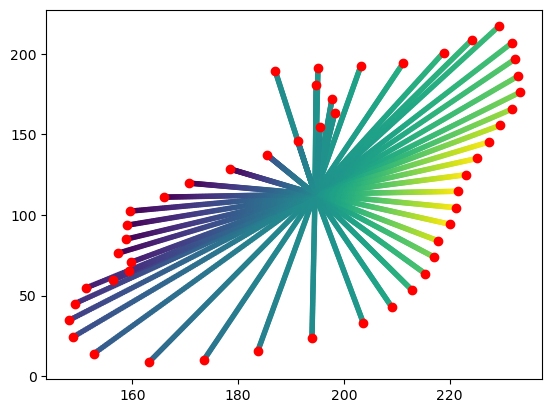

In [16]:
plt.scatter(pts[:, 0], pts[:, 1], c=values[:, 0], marker='.')
plt.scatter(sample[:, 0], sample[:, 1], c='r')

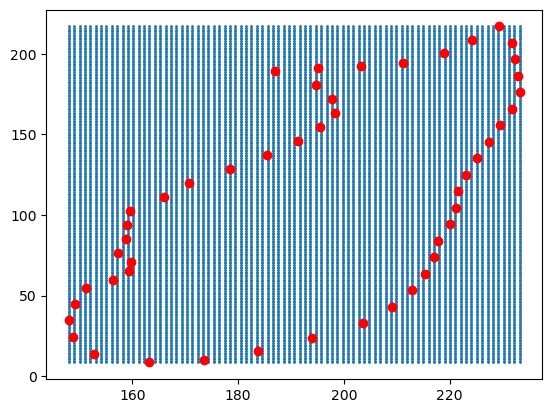

In [17]:
grid = torch.meshgrid(torch.linspace(bb_min[0], bb_max[0], range_sample_int[0]), torch.linspace(bb_min[1], bb_max[1], range_sample_int[1]), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

plt.scatter(grid[:, 0], grid[:, 1], s=1)
plt.scatter(sample[:, 0], sample[:, 1], c='r')

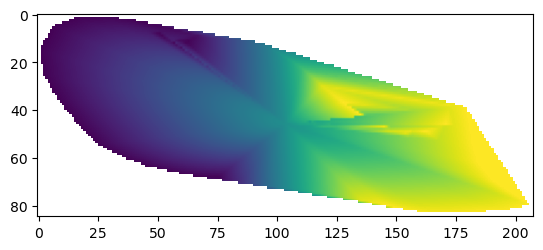

In [18]:
uv_sample = griddata(pts, values, grid, method='linear', rescale=True)
uv_sample = torch.from_numpy(uv_sample)
uv_sample = uv_sample.reshape(range_sample_int[0], range_sample_int[1], 2).permute(2, 0, 1)

plt.imshow(uv_sample[1])

Text(0.5, 1.0, 'uv map of atlas')

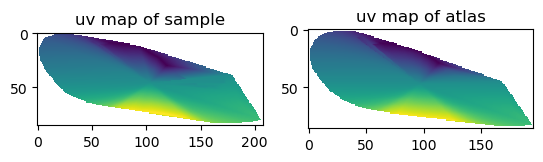

In [19]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(uv_sample[0])
axs[0].set_title('uv map of sample')
axs[1].imshow(uv[0])
axs[1].set_title('uv map of atlas')

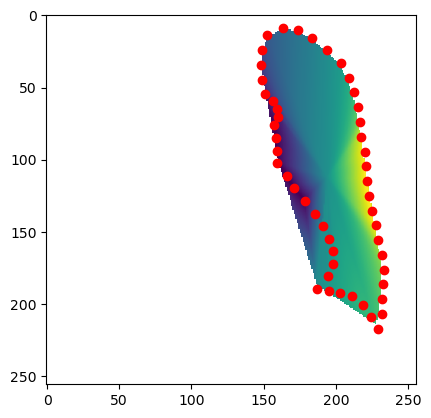

In [20]:
img_size = [256, 256]
bb_max_int = bb_max.round().int()
bb_min_int = bb_min.round().int()
target_uv_img_shape = (bb_max_int - bb_min_int).tolist()
resized_uv_img = F.interpolate(uv_sample.unsqueeze(0), target_uv_img_shape, mode='bilinear', align_corners=True).squeeze(0)

uv_sample_img_space = torch.full((2, img_size[0], img_size[1]), torch.nan)
uv_sample_img_space[:, bb_min_int[0]:bb_max_int[0], bb_min_int[1]:bb_max_int[1]] = resized_uv_img
uv_sample_img_space = uv_sample_img_space.transpose(1, 2)
# uv_img_space_masked[:, seg_mask.logical_not()] = torch.nan

plt.imshow(uv_sample_img_space[0])
plt.scatter(sample[:, 0], sample[:, 1], c='r')

In [21]:
def nanargmin(tensor, dim=None, keepdim=False):
    max_value = torch.finfo(tensor.dtype).max
    output = tensor.nan_to_num(max_value).argmin(dim=dim, keepdim=keepdim)
    return output

def convert_uv_to_coordinates(uv_map: torch.Tensor, uv_values: torch.Tensor, mode: str, k: int = None) -> torch.Tensor:
    """
    Calculate the coordinates of the uv_values in the uv_map by finding the closest uv value in the uv_map.
    UV maps may contain NaN values, which are ignored in the calculation.
    :param uv_map: UV map of shape (B, 2, H, W)
    :param uv_values: UV values of shape (B, N_c, 2) where N_c is the number of uv values for each class C
    :param mode: 'nearest' or 'linear'
    :param k: number of closest points to consider in linear mode
    :return: coordinates of the uv_values in the uv_map of shape (B, N_c, 2) where N_c is the number of uv values for each class C
    """

    assert uv_map.shape[1] == 2, 'UV map must have 2 channels'
    assert uv_values.shape[-1] == 2, 'UV values must have 2 dimensions'
    assert uv_map.shape[0] == uv_values.shape[0], 'Batch size of uv_map and uv_values must match'
    assert k is None or (k > 0 and isinstance(k, int)), 'k must be a positive integer'
    assert uv_map.isnan().logical_not().sum() >= k, 'UV map must contain at least k valid values'

    B, _, H, W = uv_map.shape
    device = uv_map.device

    # calculate the distance of each uv value to each uv coordinate
    uv_coord_dist = uv_map.view(B, 2, H * W, 1) - uv_values.transpose(1, 2).view(B, 2, 1, -1)  # (B, 2, H*W, N)
    uv_coord_dist = torch.linalg.vector_norm(uv_coord_dist, dim=1)  # (B, H*W, N)

    # extract uv coordinate
    if mode == 'nearest' or k == 1:
        uv_coord = nanargmin(uv_coord_dist, dim=1)  # (B, N)
        uv_coord = torch.stack([uv_coord // W, uv_coord % W], dim=-1)  # (B, N, 2)
    elif mode == 'linear':
        assert k is not None, 'k must be given in linear mode'
        uv_coord = torch.arange(H * W, device=device)
        uv_coord = torch.stack([uv_coord // W, uv_coord % W], dim=-1)  # (H*W, 2)
        uv_coord = uv_coord.unsqueeze(0).expand(B, H * W, -1)  # (B, H*W, 2)

        # select the k closest points
        top_k_indices = torch.topk(uv_coord_dist, k=k, dim=1, largest=False).indices  # (B, H*W, k)
        top_k_mask = torch.ones_like(uv_coord_dist, dtype=torch.bool)  # (B, H*W, N)
        top_k_mask.scatter_(1, top_k_indices, False)

        # replace non-top k values with -infinity due to its neutral behavior in the softmax (softmin: inf → -inf)
        # NaN values are already implicitly covered by top k
        uv_coord_dist = torch.where(top_k_mask, torch.inf, uv_coord_dist)
        weights = F.softmin(uv_coord_dist, dim=1)  # (B, H*W, N)
        # (B, H*W, 1, 2) * (B, H*W, N, 1) → (B, H*W, N, 2) → (B, N, 2)
        uv_coord = torch.sum(uv_coord.unsqueeze(-2) * weights.unsqueeze(-1), dim=1)
    else:
        raise ValueError(f'Unknown mode: {mode}. Has to be "nearest" or "linear".')

    # HW → WH
    uv_coord = uv_coord.flip(-1)

    return uv_coord

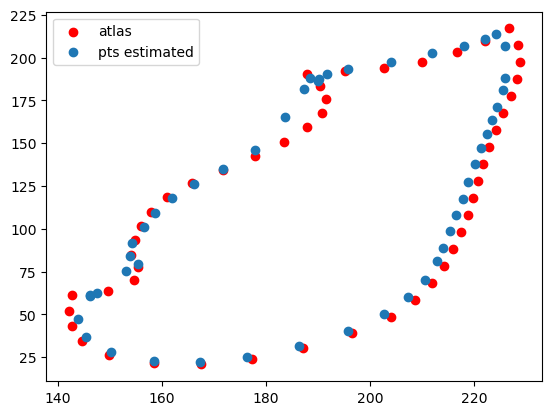

In [22]:
pts_atlas = convert_uv_to_coordinates(uv_img_space.contiguous().unsqueeze(0), atlas_pts_values.unsqueeze(0), 'linear', 5).squeeze()

plt.scatter(atlas[:, 0], atlas[:, 1], c='r', label='atlas')
plt.scatter(pts_atlas[:, 0], pts_atlas[:, 1], label='pts estimated')
plt.legend()

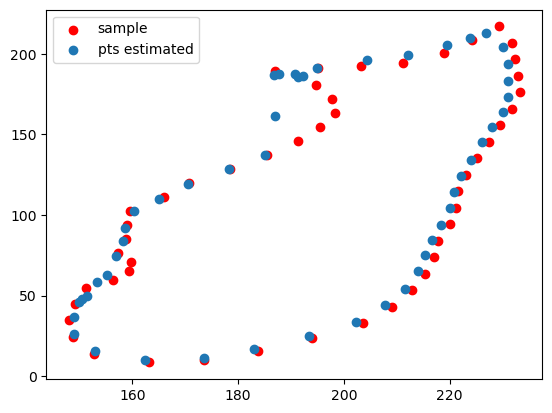

In [23]:
pts_sample = convert_uv_to_coordinates(uv_sample_img_space.contiguous().unsqueeze(0), atlas_pts_values.unsqueeze(0), 'linear', 5).squeeze()

plt.scatter(sample[:, 0], sample[:, 1], c='r', label='sample')
plt.scatter(pts_sample[:, 0], pts_sample[:, 1], label='pts estimated')
plt.legend()

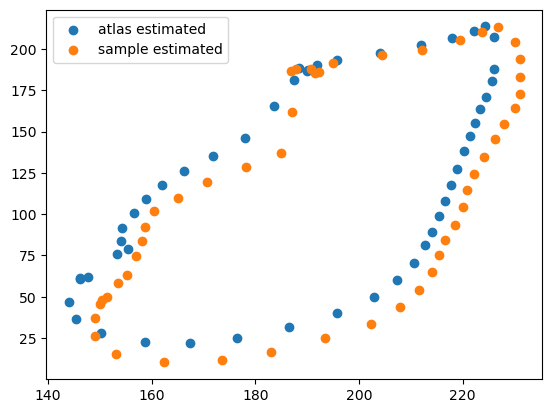

In [24]:
plt.scatter(pts_atlas[:, 0], pts_atlas[:, 1], label='atlas estimated')
plt.scatter(pts_sample[:, 0], pts_sample[:, 1], label='sample estimated')
plt.legend()